# Import Libraries

In [1]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_auc_score

import re
import string
import nltk
import itertools
import numpy as np

# this allows you to apply a progress bar to pandas operations
from tqdm import tqdm
tqdm.pandas()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Install Paddle OCR & OPENCV

In [2]:
# Github repo installation of paddle
!python -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple
# Install paddle OCR
!pip install paddleocr
# git clone
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
# cv2
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://mirror.baidu.com/pypi/simple
fatal: destination path 'PaddleOCR' already exists and is not an empty directory.


# Import Libraries 2

In [3]:
import cv2
from paddleocr import PaddleOCR, draw_ocr
from matplotlib import pyplot as plt
import os

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': Image.NEAREST,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': Image.BILINEAR,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': Image.BICUBIC,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/paddle/vision/transforms/functional_pil.py:39: DeprecationWarning: BOX is deprecated and will be removed in Pillo

# Define ocr_model = PaddleOCR. return text

In [4]:
ocr_model = PaddleOCR(lang='en')

[2023/07/13 15:38:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/home/studio-lab-user/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='/home/studio-lab-user/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_shape='3, 48, 320', rec_bat

---    Fused 0 subgraphs into layer_norm op.
---    Fused 0 subgraphs into layer_norm op.


In [5]:
path_product_id = "/home/studio-lab-user/DS-Projects/OCR/DanTDM/"
%cd "{path_product_id}"

/home/studio-lab-user/DS-Projects/OCR/DanTDM


In [6]:
from glob import glob

pos_test_img_list = glob('dantdm*') # including 120 negative images
neg_test_img_list = glob('neg*')
print("number of positive images: " + str(len(pos_test_img_list)))
print("number of negative images: " + str(len(neg_test_img_list)))

number of positive images: 19
number of negative images: 0


In [7]:
import pandas as pd
df1 = pd.DataFrame()
df1['file_name'] = pos_test_img_list
df1['relevant'] = 1

df2 = pd.DataFrame()
df2['file_name'] = neg_test_img_list
df2['relevant'] = 0
df3 = pd.concat([df1,df2]).reset_index(drop=True)
df3

,file_name,relevant
0,dantdm (11).png,1
1,dantdm (12).png,1
2,dantdm (14).png,1
3,dantdm (15).png,1
4,dantdm (16).png,1
5,dantdm (1).png,1
6,dantdm (13).png,1
7,dantdm (17).png,1
8,dantdm (18).png,1
9,dantdm (19).png,1


# Define words & Scores output from Paadle OCR

In [8]:
def get_words_and_scores_and_add_to_dataframe(row):
    photo = row["file_name"]
    if photo == "empty":
        return [[],[]]
    image_path = f"/home/studio-lab-user/DS-Projects/OCR/DanTDM/{photo}"
    result = ocr_model.ocr(image_path)
    texts = [res[1][0] for res in result]
    scores = [res[1][1] *100 for res in result]
    result = [texts, scores]
    return result

# Apply(function, axis=1) to df3. GPU takes 0.1s, CPU takes 1s

In [9]:
df3["words"] = df3.apply(get_words_and_scores_and_add_to_dataframe, axis=1)

[2023/07/13 15:38:55] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 15:38:57] ppocr DEBUG: dt_boxes num : 1, elapse : 1.2161169052124023
[2023/07/13 15:38:57] ppocr DEBUG: rec_res num  : 1, elapse : 0.09984683990478516
[2023/07/13 15:38:57] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 15:38:57] ppocr DEBUG: dt_boxes num : 1, elapse : 0.39279913902282715
[2023/07/13 15:38:57] ppocr DEBUG: rec_res num  : 1, elapse : 0.14889144897460938
[2023/07/13 15:38:57] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 15:38:58] ppocr DEBUG: dt_boxes num : 1, elapse : 0.1579604148864746
[2023/07/13 15:38:58] ppocr DEBUG: rec_res num  : 1, elapse : 0.0881643295288086
[2023/07/13 15:38:58] ppocr WARNING: Since the angle classifier 

In [10]:
len(df3)
df3.head()

,file_name,relevant,words
0,dantdm (11).png,1,"[[TOM], [90.80745577812195]]"
1,dantdm (12).png,1,"[[TDM], [94.37748789787292]]"
2,dantdm (14).png,1,"[[DANTDM], [98.49041104316711]]"
3,dantdm (15).png,1,"[[TDM], [71.70515060424805]]"
4,dantdm (16).png,1,"[[TZM, DAN, X, X], [90.45940041542053, 98.8420..."


In [11]:
def new_score_text(row):
    sample_list = row["words"][0]
    score_list = row["words"][1]
    new_text = []
    new_score = []
    for text, score in zip(sample_list, score_list): # assign text and score each
        new_text.extend(text.split()) #update new_text.
        number_of_space = text.count(" ") # number of spaces +1 is chunk of words
        for i in range(number_of_space+1):
            new_score.append(score)
            
    return [new_text, new_score]

In [12]:
df3["words"] = df3.apply(new_score_text, axis=1)

# Result of df3

In [13]:
df3.head(50)

,file_name,relevant,words
0,dantdm (11).png,1,"[[TOM], [90.80745577812195]]"
1,dantdm (12).png,1,"[[TDM], [94.37748789787292]]"
2,dantdm (14).png,1,"[[DANTDM], [98.49041104316711]]"
3,dantdm (15).png,1,"[[TDM], [71.70515060424805]]"
4,dantdm (16).png,1,"[[TZM, DAN, X, X], [90.45940041542053, 98.8420..."
5,dantdm (1).png,1,"[[DAN, TOM], [87.46448159217834, 87.4644815921..."
6,dantdm (13).png,1,"[[HATE, DanTDM!], [99.81428384780884, 97.25480..."
7,dantdm (17).png,1,"[[auuzu, TDM], [68.83577108383179, 83.00006389..."
8,dantdm (18).png,1,"[[], []]"
9,dantdm (19).png,1,"[[TOM], [87.2150182723999]]"


# Define cleaning_text. Make text lowercase and remove punctuations etc.
## Return is cleaned text and score into the list

In [14]:
import re
import string

def clean_text(row):
    word_list = row["words"][0]
    new_word_list = []
    for word in word_list:
        new_word = word.lower()
        new_word = re.sub("[%s]" % re.escape(string.punctuation), " ", new_word)
        new_word_list.append(new_word)
    return [new_word_list, row["words"][1]]

# Apply apply(function, axis=1)

In [15]:
df3["words"] = df3.apply(clean_text, axis=1)

# Result of Clean_text

In [16]:
df3.head(50)

,file_name,relevant,words
0,dantdm (11).png,1,"[[tom], [90.80745577812195]]"
1,dantdm (12).png,1,"[[tdm], [94.37748789787292]]"
2,dantdm (14).png,1,"[[dantdm], [98.49041104316711]]"
3,dantdm (15).png,1,"[[tdm], [71.70515060424805]]"
4,dantdm (16).png,1,"[[tzm, dan, x, x], [90.45940041542053, 98.8420..."
5,dantdm (1).png,1,"[[dan, tom], [87.46448159217834, 87.4644815921..."
6,dantdm (13).png,1,"[[hate, dantdm ], [99.81428384780884, 97.25480..."
7,dantdm (17).png,1,"[[auuzu, tdm], [68.83577108383179, 83.00006389..."
8,dantdm (18).png,1,"[[], []]"
9,dantdm (19).png,1,"[[tom], [87.2150182723999]]"


# Targets

In [56]:
## define the target words / phrases
targets = ["dantdm", "tom", "tdm", "dan"]

# Get_final_score. each word from text is called sample.
1. calculate the edit_distance between target and sample 
2. calculate the closeness (how similar two words)
3. confidence_score_mean (don't know why confidence_score_mean. Can I use just confidencescore as a score?
4. final score = similarity * confidence score
5. If final score is higher than Max_score =0, max_score is replaced. The highest final score will be the max_score at the end

In [57]:
# helper functions for funal scoring function

def advance(iterator, step):
    next(itertools.islice(iterator, step, step), None)


def tuplewize(iterable, size):
    iterators = itertools.tee(iterable, size)
    for position, iterator in enumerate(iterators):
        advance(iterator, position)
    return zip(*iterators)

In [58]:
# define function to produce final scores

def get_final_score(row):
    sample_list = row["words"][0]
    score_list = row["words"][1]
    max_score = 0
    
    for target in targets:
        phrase_length = len(target.split())
        for i in range(1, phrase_length+1):
            for c, s in zip(tuplewize(sample_list, i), tuplewize(score_list, i)):
                new_sample = " ".join(c)
                edit_distance = nltk.edit_distance(target, new_sample)
                closeness = (len(target)-edit_distance)/len(target)
                confidence_score = np.mean(s)
                final_score = closeness * confidence_score
                if final_score > max_score:
                    max_score = final_score
             
    return max_score

# Calculate OCR_score which is Max_score from get_final_score function

In [59]:
df3["OCR_score"] = df3.apply(get_final_score, axis=1)
df3.head(50)

,file_name,relevant,words,OCR_score
6,dantdm (13).png,1,"[[hate, dantdm ], [99.81428384780884, 97.25480...",81.045667
10,dantdm (2).png,1,"[[tom, dan], [96.25181555747986, 99.3386268615...",99.338627
18,dantdm (10).png,1,"[[tom, dan, x], [84.11763310432434, 98.9108502...",98.910850
5,dantdm (1).png,1,"[[dan, tom], [87.46448159217834, 87.4644815921...",87.464482
2,dantdm (14).png,1,"[[dantdm], [98.49041104316711]]",98.490411
4,dantdm (16).png,1,"[[tzm, dan, x, x], [90.45940041542053, 98.8420...",98.842001
16,dantdm (8).png,1,"[[tdmon, tour], [79.30853366851807, 79.3085336...",26.436178
17,dantdm (9).png,1,"[[dantdm], [70.97094655036926]]",70.970947
7,dantdm (17).png,1,"[[auuzu, tdm], [68.83577108383179, 83.00006389...",83.000064
13,dantdm (5).png,1,"[[tom], [97.72078394889832]]",97.720784


# display the dataframe sort by OCR_score

In [60]:
df3 = df3.sort_values(by='OCR_score', ascending=False)
pd.set_option('display.max_rows', None)
df3

,file_name,relevant,words,OCR_score
10,dantdm (2).png,1,"[[tom, dan], [96.25181555747986, 99.3386268615...",99.338627
18,dantdm (10).png,1,"[[tom, dan, x], [84.11763310432434, 98.9108502...",98.910850
4,dantdm (16).png,1,"[[tzm, dan, x, x], [90.45940041542053, 98.8420...",98.842001
2,dantdm (14).png,1,"[[dantdm], [98.49041104316711]]",98.490411
13,dantdm (5).png,1,"[[tom], [97.72078394889832]]",97.720784
1,dantdm (12).png,1,"[[tdm], [94.37748789787292]]",94.377488
0,dantdm (11).png,1,"[[tom], [90.80745577812195]]",90.807456
15,dantdm (7).png,1,"[[tom], [89.32154178619385]]",89.321542
5,dantdm (1).png,1,"[[dan, tom], [87.46448159217834, 87.4644815921...",87.464482
9,dantdm (19).png,1,"[[tom], [87.2150182723999]]",87.215018


# ROCAUC score

In [22]:
RA_score = roc_auc_score(df3["relevant"], df3["OCR_score"])

print("Rekognition ROC AUC Score =  %.2f" % (RA_score))

Rekognition ROC AUC Score =  0.82


# Save the dataframe as a csv

In [23]:
df3.to_csv('/home/studio-lab-user/DS-Projects/OCR/Instax.csv')

In [24]:
# Dataframe of true positives

tp = df3.loc[(df3['relevant'] == 1) & (df3['OCR_score'] >= 50)] 
print(len(tp))

78


In [25]:
# Dataframe of true negatives

tn = df3.loc[(df3['relevant'] == 0) & (df3['OCR_score'] < 50)] 
print(len(tn))

216


In [26]:
# Dataframe of false positives

fp = df3.loc[(df3['relevant'] == 0) & (df3['OCR_score'] >= 50)] 
print(len(fp))

0


In [27]:
# Dataframe of false negatives

fn = df3.loc[(df3['relevant'] == 1) & (df3['OCR_score'] < 50)] 
print(len(fn))

24


In [28]:
# Precision (What % of irdentified positives and true?)
precision = len(tp) / (len(tp) + len(fp))
print(precision)

1.0


In [29]:
# PRecall (% of true positives identified)
recall = len(tp) / (len(tp) + len(fn))
print(recall)

0.7647058823529411


In [30]:
fn

,file_name,relevant,words,OCR_score
8,pos (12).jpg,1,"[[instaxn s, boo], [80.72419166564941, 57.9865...",40.362096
59,pos (56).jpg,1,"[[instaxidea, booklet], [96.46182656288147, 96...",32.153942
69,pos (79).jpg,1,"[[ofuuafin, suxeilm, instaxmini, 10], [51.2148...",30.924193
94,pos (82).jpg,1,"[[instaxmini, link], [81.45999908447266, 81.45...",27.153333
23,pos (26).jpg,1,"[[mini, nstantfilm, 20pcs, fit fuji, pat, mini...",24.946201
22,pos (29).jpg,1,"[[], []]",0.000000
19,pos (24).jpg,1,"[[], []]",0.000000
16,pos (25).jpg,1,"[[], []]",0.000000
13,pos (20).jpg,1,"[[], []]",0.000000
12,pos (17).jpg,1,"[[], []]",0.000000


# Visualisation

In [12]:
%cd /home/studio-lab-user/DS-Projects/OCR_Module/PaddleOCR

ocr_model = PaddleOCR(lang='en')

def extract_text(image_path):
    result = ocr_model.ocr(image_path)
    
    return [res[1][0] for res in result]

/home/studio-lab-user/DS-Projects/OCR_Module/PaddleOCR
[2023/07/13 15:34:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/home/studio-lab-user/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='/home/studio-lab-user/.paddleocr/whl/rec/en/en_PP-

---    Fused 0 subgraphs into layer_norm op.
---    Fused 0 subgraphs into layer_norm op.


In [13]:
# image_path = "/home/studio-lab-user/DS-Projects/OCR/Instax"
# Better image based examples
# image_path = "/home/studio-lab-user/DS-Projects/OCR/image-based-examples/"
image_path = "/home/studio-lab-user/DS-Projects/OCR/DanTDM/"
font_path = "/home/studio-lab-user/DS-Projects/OCR/PaddleOCR/doc/fonts/latin.ttf"

In [14]:
%cd /home/studio-lab-user/DS-Projects/OCR/PaddleOCR

/home/studio-lab-user/DS-Projects/OCR/PaddleOCR


In [15]:
def visualisation(image_path):
    result = ocr_model.ocr(image_path)
    boxes = [res[0] for res in result]
    texts = [res[1][0] for res in result]
    scores = [res[1][1] for res in result]
    img = cv2.imread(img_path) # import images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # reorders the colour channels
    
    plt.figure(figsize=(15,15))
    annotated = draw_ocr(img, boxes, texts, scores)
    plt.imshow(annotated)

[2023/07/13 15:37:21] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 15:37:21] ppocr DEBUG: dt_boxes num : 2, elapse : 0.3347434997558594
[2023/07/13 15:37:22] ppocr DEBUG: rec_res num  : 2, elapse : 0.32575130462646484
[2023/07/13 15:37:22] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 15:37:22] ppocr DEBUG: dt_boxes num : 2, elapse : 0.27221107482910156
[2023/07/13 15:37:22] ppocr DEBUG: rec_res num  : 2, elapse : 0.17064213752746582


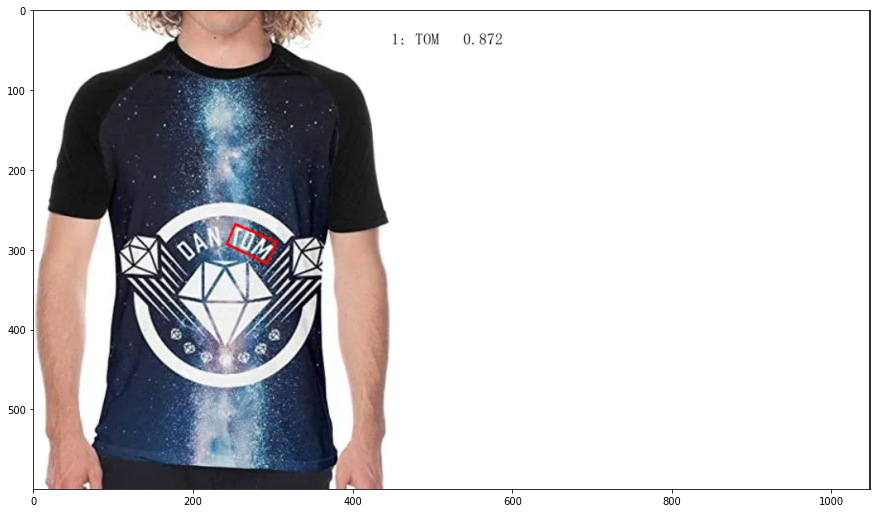

In [35]:
img_path = f'{image_path}/dantdm (19).png'
extract_text(img_path)
visualisation(img_path)

[2023/07/13 10:42:37] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 10:42:37] ppocr DEBUG: dt_boxes num : 0, elapse : 0.08677887916564941
[2023/07/13 10:42:37] ppocr DEBUG: rec_res num  : 0, elapse : 1.9073486328125e-06
[2023/07/13 10:42:37] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/07/13 10:42:37] ppocr DEBUG: dt_boxes num : 0, elapse : 0.06888365745544434
[2023/07/13 10:42:37] ppocr DEBUG: rec_res num  : 0, elapse : 1.430511474609375e-06


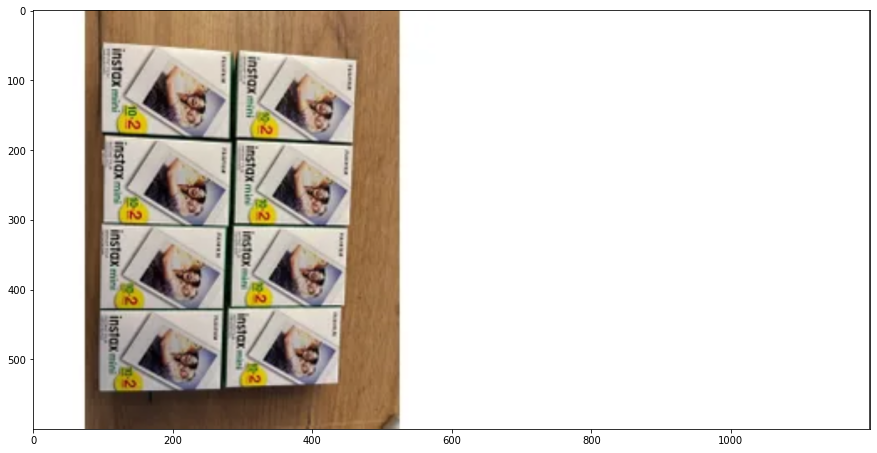

In [12]:
img_path = f'{image_path}/pos (76).jpg'
extract_text(img_path)
visualisation(img_path)